## Need to get accurate detection working.

In [10]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.style.use('ggplot')
import pandas as pd

class sizeme():
    """ Class to change html fontsize of object's representation"""
    def __init__(self,ob, size=50, height=120):
        self.ob = ob
        self.size = size
        self.height = height
    def _repr_html_(self):
        repl_tuple = (self.size, self.height, self.ob._repr_html_())
        return u'<span style="font-size:{0}%; line-height:{1}%">{2}</span>'.format(*repl_tuple)

pd.options.display.max_columns = 9999
pd.set_option('display.width', 9999)

Use the code from `diffimTests.py`.

In [11]:
import diffimTests as dit
reload(dit)

# Let's try w same parameters as ZOGY paper.
sky = 300.

testObj = dit.DiffimTest(imSize=(512,512), sky=sky, offset=[0,0], psf_yvary_factor=0., 
                         varSourceChange=[1500., 1600., 1800., 2000., 2200., 2400., 2600., 2800.],
                         theta1=0., theta2=-45., im2background=0., n_sources=50, sourceFluxRange=(500,30000), 
                         seed=66, psfSize=13)

print dit.computeClippedImageStats(testObj.im1.im)
print dit.computeClippedImageStats(testObj.im2.im)
print dit.computeClippedImageStats(testObj.im1.var)
print dit.computeClippedImageStats(testObj.im2.var)

(0.058941207521673616, 17.142582277831181, -74.0, 1741.5550996425638)
(0.16640941424314851, 17.212254472642801, -82.0, 1169.0572762553779)
(300.05894120752163, 17.142582277831185, 226.0, 2041.5550996425638)
(300.16640941424311, 17.212254472642801, 218.0, 1469.0572762553779)


In [12]:
res = testObj.doALInStack(doPreConv=False, doDecorr=True)
D_AL = res.decorrelatedDiffim.getMaskedImage().getImage().getArray()
print np.sum((D_AL == 0) | np.isnan(D_AL) | np.isinf(D_AL))
#D_AL[0,:] = D_AL[:,0] = D_AL[-1,:] = D_AL[:,-1] = np.nan
D_AL[np.isnan(D_AL) | np.isinf(D_AL)] = np.nan
print dit.computeClippedImageStats(D_AL, ignore=[0.])
D_ZOGY = testObj.doZOGY()
print np.sum((D_ZOGY.im == 0) | np.isnan(D_ZOGY.im) | np.isinf(D_ZOGY.im))
#D_ZOGY.im[np.isnan(D_AL)] = np.nan
print dit.computeClippedImageStats(D_ZOGY.im, ignore=[0.])
# Note that measurement stats (PeakLikelihoodFlux) works more accurately on S than S_corr (b/c of variance plane)
S_ZOGY = testObj.S_ZOGY   # S_corr_ZOGY
print np.sum((S_ZOGY.im == 0) | np.isnan(S_ZOGY.im) | np.isinf(S_ZOGY.im))
#S_ZOGY.im[np.isnan(D_AL)] = np.nan
print dit.computeClippedImageStats(S_ZOGY.im, ignore=[0.])

D_AL2, _ = testObj.doAL(spatialKernelOrder=0, spatialBackgroundOrder=1)
D_AL2.im[np.isnan(D_AL)] = np.nan
print dit.computeClippedImageStats(D_AL2.im, ignore=[0.])

54208
(0.024174426, 24.070663, -116.10862, 253.13861)
0
(0.00055268522006568347, 0.98760104887052125, -4.8672645302908411, 6.8441350122300415)
0
(8.0726821651100822e-05, 0.006113246212468869, -0.028160916669297618, 0.112995552495201)
(-0.0031277323076849867, 0.98411642527827314, -4.7277879267653544, 6.6571256211881131)


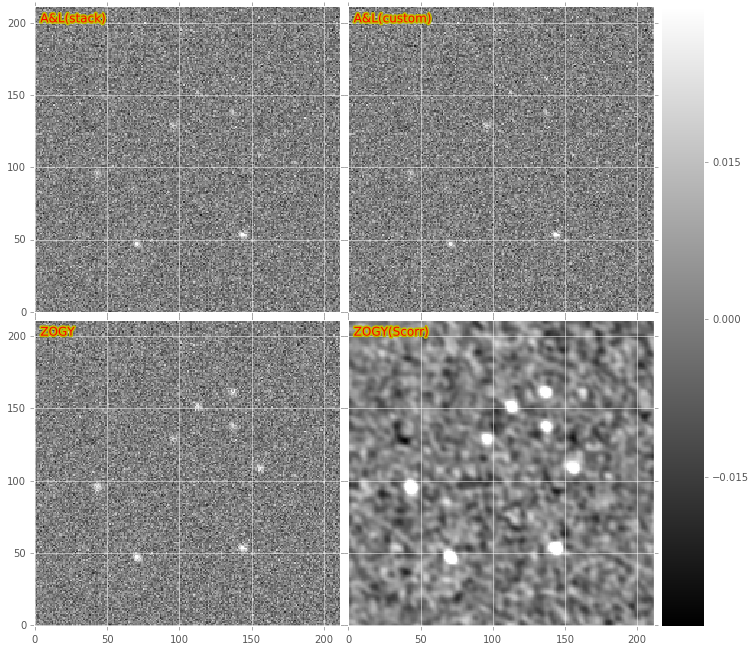

In [13]:
fig = plt.figure(1, (12, 12))
x1d, x2d, y1d, y2d = 150, 512-150, 150, 512-150   # limits for display
dit.plotImageGrid((D_AL[x1d:x2d,y1d:y2d], D_AL2.im[x1d:x2d,y1d:y2d], 
                   D_ZOGY.im[x1d:x2d,y1d:y2d], S_ZOGY.im[x1d:x2d,y1d:y2d]), 
                 titles=['A&L(stack)', 'A&L(custom)', 'ZOGY', 'ZOGY(Scorr)'])

In [16]:
reload(dit)

changedCentroid = testObj.centroids[testObj.changedCentroidInd, :]
print changedCentroid

# update: need to set mask on edge values. They're zero so they're setting the stdev of the image too low.
src_AL = dit.doDetection(res.decorrelatedDiffim)
src_AL_nodecorr = dit.doDetection(res.subtractedExposure)
#src_AL2 = dit.doDetection(D_AL2.asAfwExposure())
src_ZOGY = dit.doDetection(D_ZOGY.asAfwExposure())
src_ZOGY2 = dit.doDetection(D_ZOGY.asAfwExposure(), threshold=4.95)  # Looks like the 2nd source is a 4.95-sigma guy
src_SZOGY = dit.doDetection(S_ZOGY.asAfwExposure(), doSmooth=False)

df = pd.DataFrame({col: src_AL.columns[col] for col in src_AL.schema.getNames()})
print df[['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
df = pd.DataFrame({col: src_AL_nodecorr.columns[col] for col in src_AL_nodecorr.schema.getNames()})
print df[['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
df = pd.DataFrame({col: src_ZOGY.columns[col] for col in src_ZOGY.schema.getNames()})
print df[['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PsfFlux_fluxSigma', 'base_PsfFlux_flag']]
# For SZOGY, the correct flux measurement is PeakLikelihoodFlux
df = pd.DataFrame({col: src_SZOGY.columns[col] for col in src_SZOGY.schema.getNames()})
print df[['base_NaiveCentroid_x', 'base_NaiveCentroid_y', 'base_PeakLikelihoodFlux_fluxSigma', 'base_PsfFlux_flag']]

[[   245.89925013    279.36159005   1423.89964966   2923.89964966]
 [   287.15359438    287.4644825   11199.22125222  12799.22125222]
 [   262.66886207    301.46927489  20097.66173206  21897.66173206]
 [   305.71844991    258.5881023   27152.92647256  29152.92647256]
 [   286.8634569     311.26461378  26439.91024586  28639.91024586]
 [   193.35871751    245.82202312  16949.74839209  19349.74839209]
 [   293.52593604    203.14457926   4226.31645367   6826.31645367]
 [   220.82192365    196.83656518  14224.08558878  17024.08558878]]
   base_NaiveCentroid_x  base_NaiveCentroid_y  base_PsfFlux_fluxSigma base_PsfFlux_flag
0            415.146707             34.248999                     NaN              True
1             35.130174            134.019642                     NaN              True
2            220.281251            196.981653              244.078959             False
3            293.161952            203.164991              200.085437             False
4            193.111072

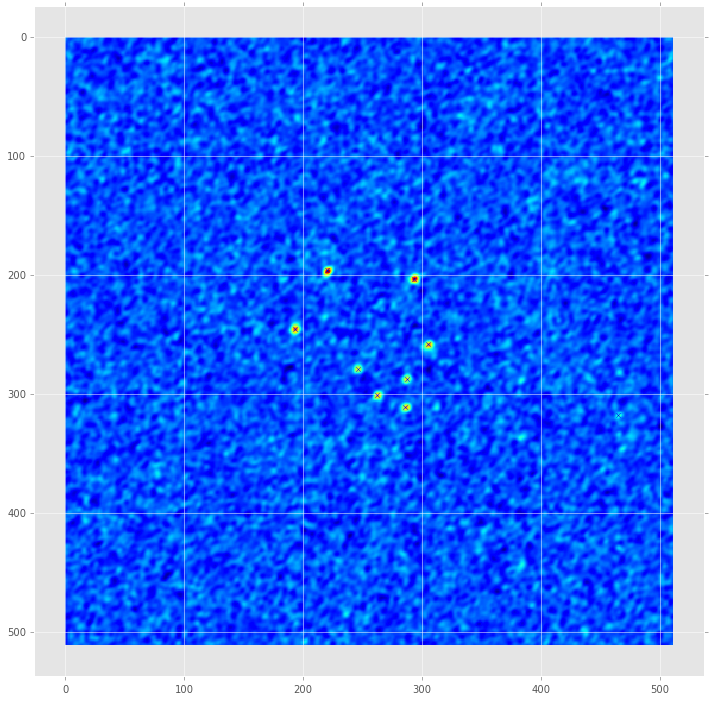

In [17]:
df = pd.DataFrame({col: src_SZOGY.columns[col] for col in src_SZOGY.schema.getNames()})
fig = plt.figure(1, (12, 12))
plt.imshow(S_ZOGY.im, interpolation='none')
plt.scatter(df.base_NaiveCentroid_x.values, df.base_NaiveCentroid_y.values, marker='x')

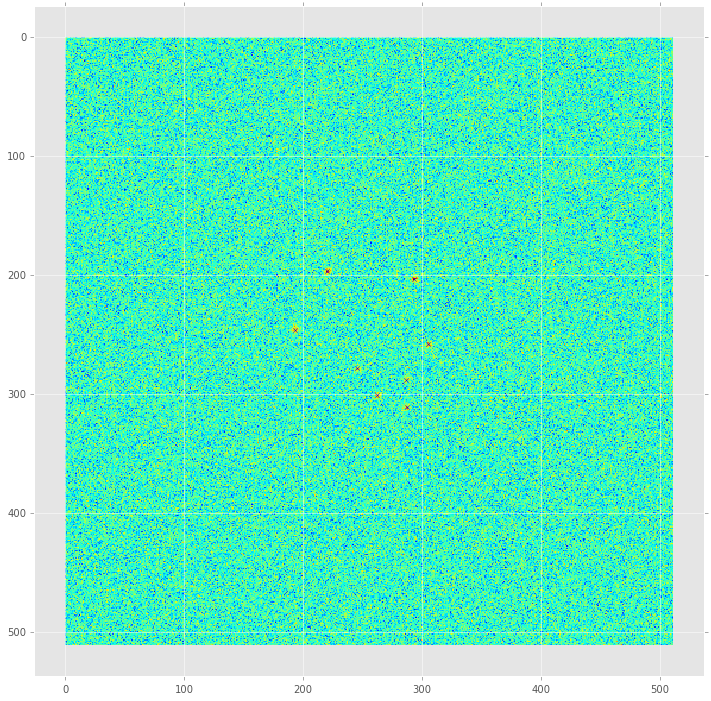

In [18]:
df = pd.DataFrame({col: src_ZOGY.columns[col] for col in src_ZOGY.schema.getNames()})
fig = plt.figure(1, (12, 12))
plt.imshow(D_ZOGY.im, interpolation='none')
plt.scatter(df.base_NaiveCentroid_x.values, df.base_NaiveCentroid_y.values, marker='x')

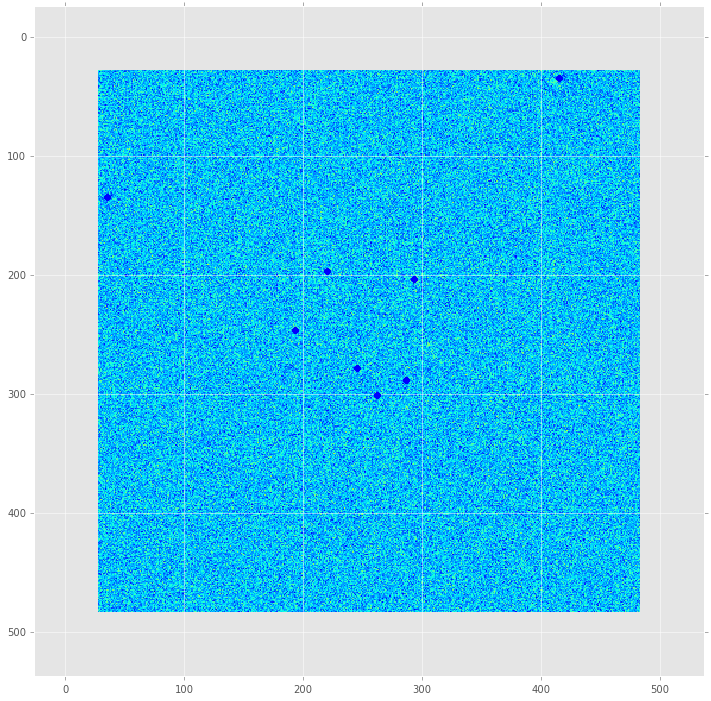

In [24]:
df = pd.DataFrame({col: src_AL.columns[col] for col in src_AL.schema.getNames()})
fig = plt.figure(1, (12, 12))
plt.imshow(D_AL, interpolation='none')
plt.scatter(df.base_NaiveCentroid_x.values, df.base_NaiveCentroid_y.values, marker='x', linewidth=5)

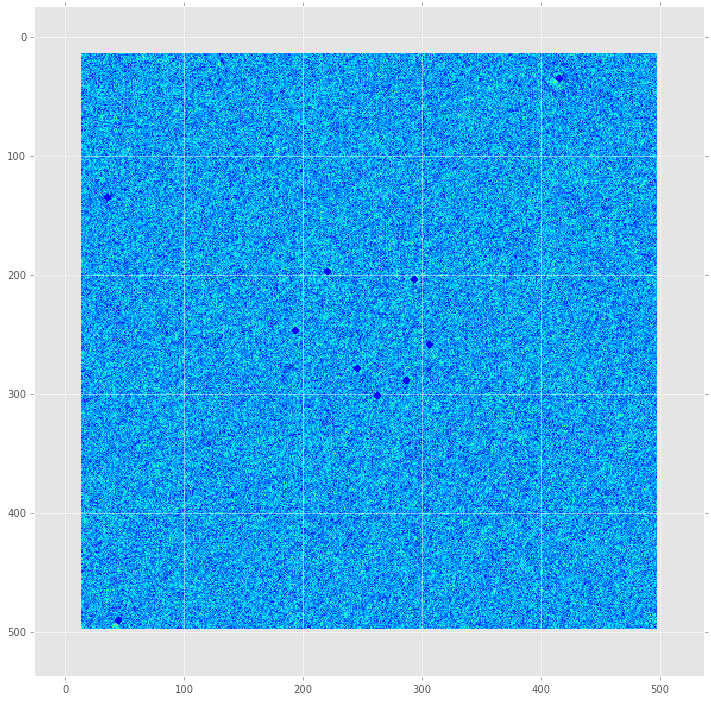

In [28]:
df = pd.DataFrame({col: src_AL_nodecorr.columns[col] for col in src_AL_nodecorr.schema.getNames()})
fig = plt.figure(1, (12, 12))
plt.imshow(res.subtractedExposure.getMaskedImage().getImage().getArray(), interpolation='none')
plt.scatter(df.base_NaiveCentroid_x.values, df.base_NaiveCentroid_y.values, marker='x', linewidth=5)

1.0


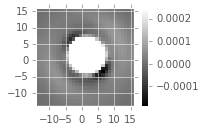

In [9]:
print res.decorrelatedDiffim.getPsf().computeImage().getArray().sum()
dit.plotImageGrid((res.decorrelatedDiffim.getPsf().computeImage(),))

## Need to udnerstand why A&L is doing so poorly. 

Let's ave out our simulated images and run `imageDifference.py` on them.

In [30]:
im1 = testObj.im1.asAfwExposure()
im1.writeFits('test_imageDifference/im1.fits')
im2 = testObj.im2.asAfwExposure()
im2.writeFits('test_imageDifference/im2.fits')